# Visualize null DWPCs and gamma-hurdle models

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import scipy.sparse
import scipy.special
import scipy.stats
import tqdm
import requests

import hetmatpy
import hetmatpy.degree_group
import hetmatpy.degree_weight

## Parameters

Parameters correspond to [this connectivity search](https://het.io/search/?source=17287&target=7607). See also the corresponding expanded metapaths table screenshot:

![](https://github.com/greenelab/connectivity-search-manuscript/raw/b290b4ad435553c7126867e0720f3112b4692809/content/media/webapp/v3/b.metapaths-expanded.png)

In [2]:
# Parameters
source_id = 17287
target_id = 7607
metapaths = [
    'DaGiGpPW',
    'DrDuGpPW',
#     'DdGpPW',
    'DrDaGpPW',
]

In [3]:

url = f"https://search-api.het.io/v1/metapaths/source/{source_id}/target/{target_id}/?complete"
api_metapaths = requests.get(url).json()
print(f"{api_metapaths['source']['name']} --- {api_metapaths['target']['name']}")

Alzheimer's disease --- Circadian rythm related genes


In [4]:
metapath_info = dict()
for metapath in metapaths:
    url = f"https://search-api.het.io/v1/paths/source/{source_id}/target/{target_id}/metapath/{metapath}/?limit=1"
    response = requests.get(url)
    response.raise_for_status()
    print(response.url)
    metapath_info[metapath] = response.json()["path_count_info"]

https://search-api.het.io/v1/paths/source/17287/target/7607/metapath/DaGiGpPW/?limit=1
https://search-api.het.io/v1/paths/source/17287/target/7607/metapath/DrDuGpPW/?limit=1
https://search-api.het.io/v1/paths/source/17287/target/7607/metapath/DrDaGpPW/?limit=1


In [5]:
metapath_df = pd.DataFrame(list(metapath_info.values()))
metapath_df.transpose()

,0,1,2
adjusted_p_value,0.00121491,0.0851695,0.205384
cypher_query,MATCH path = (n0:Disease)-[:ASSOCIATES_DaG]-(n...,MATCH path = (n0:Disease)-[:RESEMBLES_DrD]-(n1...,MATCH path = (n0:Disease)-[:RESEMBLES_DrD]-(n1...
dgp_id,25450179,26528626,26399458
dgp_n_dwpcs,200,2800,2800
dgp_n_nonzero_dwpcs,200,1428,2718
dgp_nonzero_mean,1.98894,1.50788,1.05618
dgp_nonzero_sd,0.185322,0.660257,0.548038
dgp_reversed,False,False,False
dgp_source_degree,196,3,3
dgp_target_degree,201,201,201


## Compute null DWPCs

In [6]:
hetionet = hetmatpy.hetmat.HetMat('../../data/hetionet-v1.0.hetmat/')

In [7]:
def matrix_to_dgp(matrix, dwpc_scaler, source_degree_to_ind, target_degree_to_ind):
    rows = dict()
    if scipy.sparse.issparse(matrix):
        matrix = matrix.toarray()
    
    for source_degree, row_inds in source_degree_to_ind.items():
        row_matrix = matrix[row_inds, :]
        for target_degree, col_inds in target_degree_to_ind.items():
            if source_degree == 0 or target_degree == 0:
                continue
            slice_matrix = row_matrix[:, col_inds]
            values = numpy.arcsinh(slice_matrix / dwpc_scaler)
            rows[(source_degree, target_degree)] = values.flatten().tolist()
    return rows

def metapath_to_null_dwpcs(hetmat, metapath, degree_combos=None):
    """if degree_combos is not None, only compute these combos"""
    _, _, pc_matrix = hetmatpy.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.0)
    _, _, dwpc_matrix = hetmatpy.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.5)
    scaler = dwpc_matrix.mean()

    source_degree_to_ind, target_degree_to_ind = hetmatpy.degree_group.metapath_to_degree_dicts(hetmat, metapath)
    degree_group_to_null_dwpcs = dict()
    for name, permat in tqdm.tqdm(hetmat.permutations.items()):
        _, _, matrix = hetmatpy.degree_weight.dwpc(permat, metapath, damping=0.5, dense_threshold=0.7)
        degree_to_dgp = matrix_to_dgp(matrix, scaler, source_degree_to_ind, target_degree_to_ind)
        for degree_combo, _null_dwpcs in degree_to_dgp.items():
            if degree_combos is not None and degree_combo not in degree_combos:
                continue
            null_dwpcs = degree_group_to_null_dwpcs.setdefault(degree_combo, [])
            null_dwpcs.extend(_null_dwpcs)
    return degree_group_to_null_dwpcs

In [8]:
for metapath in metapaths:
    info = metapath_info[metapath]
    degree_combo = info["dgp_source_degree"], info["dgp_target_degree"]
    degree_groups = metapath_to_null_dwpcs(hetionet, metapath, degree_combos=[degree_combo])
    null_dwpcs = degree_groups[degree_combo]
    info["null_dwpcs"] = null_dwpcs

100%|██████████| 200/200 [00:19<00:00, 10.10it/s]


## Model null DWPCs

In [9]:
class Gamma_Hurdle:
    """
    Class for Gamma-Hurdle null DWPC distribution. Consider moving to Hetmatpy
    """
    def __init__(self):
        self.alpha = None
        self.beta = None
        self.n = None
        self.nnz = None
        self.mean_nz = None
        self.sd_nz = None
        self._gamma_coef = None
        self._prop_nonzero = None
    
    def fit_to_values(self, values):
        values = numpy.array(values)
        self.n = len(values)
        self.nnz = len(values[values > 0])
        dwpc_sum = numpy.sum(values)
        dwpc_sum_sq = numpy.sum([i**2 for i in values])
        self.mean_nz = dwpc_sum / self.nnz
        self.sd_nz = ((dwpc_sum_sq - (dwpc_sum**2) / self.nnz) / (self.nnz - 1)) ** 0.5
        self._fit()

    def fit_to_summary_stats(self, n, nnz, mean_nz, sd_nz):
        self.n = n
        self.nnz = nnz
        self.mean_nz = mean_nz
        self.sd_nz = sd_nz
        self._fit()
        
    def _fit(self):
        self.beta = self.mean_nz / self.sd_nz ** 2
        self.alpha = self.mean_nz * self.beta
        self._gamma_coef = (self.beta ** self.alpha) / scipy.special.gamma(self.alpha)
        self._prop_nonzero = self.nnz / self.n
        
    def pdf(self, x):
        if type(x) == numpy.ndarray:
            return [self.pdf(i) for i in x]
        else:
            return self._prop_nonzero * self._gamma_coef * (x ** (self.alpha - 1)) * numpy.exp(- self.beta * x)
    
    def cdf(self, x):
        if type(x) == numpy.ndarray:
            return [self.cdf(i) for i in x]
        else:
            return (1 - self._prop_nonzero) + self._prop_nonzero * scipy.special.gammainc(self.alpha, self.beta * x)
    
    def __repr__(self):
        return f"Nonzero={self._prop_nonzero:.2%}, alpha={self.alpha}, beta={self.beta}"

### Fit gamma-hurdle models

Check null DWPC summary stats give same distribution as running on all values

In [10]:
for info in metapath_info.values():
    model_from_values = Gamma_Hurdle()
    model_from_values.fit_to_values(info["null_dwpcs"])
    info["dgp_model_from_values"] = model_from_values
    
    model_from_stats = Gamma_Hurdle()
    model_from_stats.fit_to_summary_stats(info["dgp_n_dwpcs"], info["dgp_n_nonzero_dwpcs"], info["dgp_nonzero_mean"], info["dgp_nonzero_sd"])
    info["dgp_model_from_stats"] = model_from_stats

info["metapath_name"], info["dgp_model_from_values"], info["dgp_model_from_stats"]

('Disease–resembles–Disease–associates–Gene–participates–Pathway',
 Nonzero=97.07%, alpha=3.714110283740423, beta=3.5165525550362213,
 Nonzero=97.07%, alpha=3.7141102837404403, beta=3.5165525550362466)

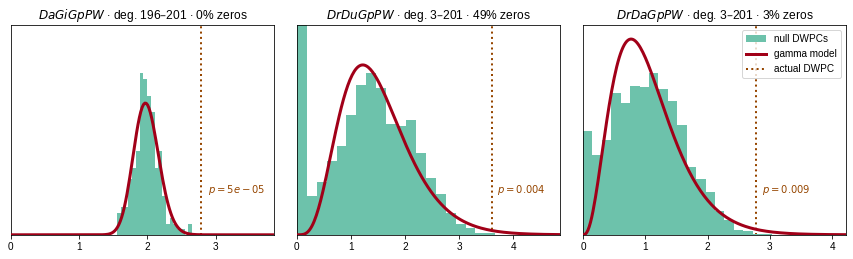

In [36]:
matplotlib.rcParams['figure.figsize'] = (12, 3.7)
matplotlib.rcParams['font.sans-serif'] = "Liberation Sans"
matplotlib.rcParams['font.family'] = "sans-serif"

figure, axes = plt.subplots(nrows=1, ncols=len(metapath_info))

for i, info, ax in zip(range(len(metapath_info)), metapath_info.values(), axes):
    model = info["dgp_model_from_values"]
    model_x = numpy.linspace(0, 10, 500)
    model_y = model.pdf(model_x)
    bar_heights, hist_bins, _ = ax.hist(
        info["null_dwpcs"],
        density=True,
        label='null DWPCs',
        color="#6dc2ab",
        bins=20,
        zorder=1,
    )
    ymax = 1.3 * max(bar_heights[1:])
    ax.plot(
        model_x,
        model_y,
        linewidth=3,
        label='gamma model',
        zorder=3,
        color="#a10018",
    )
    ax.axvline(
        x=info['dwpc'],
        zorder=0,
        linestyle="dotted",
        color="#964600",
        linewidth=2,
        label="actual DWPC",
    )
    ax.text(
        x=info['dwpc'] + 0.1,
        y = ymax * .2,
        s=f"$p={info['p_value']:.1g}$",
        color="#964600",
    )
    ax.get_xaxis().set_ticks(numpy.arange(10))
    ax.get_yaxis().set_visible(False)
    if i + 1 == len(metapath_info):
        # reorder legend https://stackoverflow.com/a/27512450/4651668
        order = [2, 0, 1]
        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[i] for i in order]
        labels = [labels[i] for i in order]
        ax.legend(handles, labels)
    ax.set_xlim((0), max(hist_bins) + 1.2)
    ax.set_ylim((0, ymax))
    ax.set_title(
        f'${info["metapath_abbreviation"]}$ · deg. {info["dgp_source_degree"]:,}–{info["dgp_target_degree"]:,} · {1 - model.nnz / model.n:.0%} zeros'
    )
figure.tight_layout()
plt.savefig("gamma-hurdle-distributions.png", dpi=300)
plt.savefig("gamma-hurdle-distributions.pdf")

In [12]:
# see available fonts
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')